<a href="https://colab.research.google.com/github/atharvakale31/Early-prediction-of-Alzheimer-using-acoustic-biomarkers/blob/main/Early_prediction_of_Alzheimer's_based_on_voice_recordings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.9 MB/s eta 0:00:00


In [8]:
import xgboost as xgb
RANDOM_STATE = 42
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV # Import RandomizedSearchCV
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [12]:
from lightgbm.callback import early_stopping, log_evaluation
import lightgbm.callback as LightGBMCallback

In [2]:
# Step 1: Set Up the Environment
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



# Load the data
metadata = pd.read_csv('/content/metadata.csv')
train_features = pd.read_csv('/content/train_features.csv')
train_labels = pd.read_csv('/content/train_labels.csv')
test_features = pd.read_csv('/content/test_features.csv')

# Display the first few rows of each dataframe
print("Metadata Sample:\n", metadata.head())
print("\nTrain Features Sample:\n", train_features.head())
print("\nTrain Labels Sample:\n", train_labels.head())
print("\nTest Features Sample:\n", test_features.head())


Metadata Sample:
     uid  age  gender  split                              hash  filesize_kb
0  aaop   72  female  train  e4ed5943c8460c2cf324d4a23c7d6fa1      186.144
1  aazd   82    male   test  fc7ef901807e2fb07cfedde8545a7fec      292.272
2  abgk   80    male  train  c6ca4b23c8a920a6ac950dbec2b58059      136.368
3  ablf   64    male  train  c646601370d5d8807f6b15d06fd40dd2      139.896
4  acad   76  female  train  2f0a0eea8caadcc7094af9e91fc88131      290.208

Train Features Sample:
     uid  segment_start_sec  segment_end_sec  \
0  aaop                0.0              0.2   
1  aaop                0.1              0.3   
2  aaop                0.2              0.4   
3  aaop                0.3              0.5   
4  aaop                0.4              0.6   

   F0semitoneFrom27.5Hz_sma3nz_amean  F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
0                          38.605347                                0.009719   
1                          15.119725                            

In [3]:
# Check class distribution
print("\nClass distribution in training set:")
print(train_labels[['diagnosis_control', 'diagnosis_mci', 'diagnosis_adrd']].sum())

# Check number of segments per individual
segments_per_uid = train_features.groupby('uid').size()
print("\nSegments per individual statistics:")
print(segments_per_uid.describe())

# Check for missing values
print("\nMissing values in train features:")
print(train_features.isnull().sum().sum())


Class distribution in training set:
diagnosis_control    911.0
diagnosis_mci        217.0
diagnosis_adrd       518.0
dtype: float64

Segments per individual statistics:
count    1646.000000
mean      270.781288
std        52.116232
min        12.000000
25%       256.250000
50%       300.000000
75%       300.000000
max       300.000000
dtype: float64

Missing values in train features:
0


In [4]:
# Function to create aggregated features for each individual
def create_aggregated_features(features_df):
    # List of aggregation functions to apply
    agg_functions = ['mean', 'std', 'min', 'max', 'median']

    # Skip these columns for aggregation
    cols_to_skip = ['uid', 'segment_start_sec', 'segment_end_sec']

    # Get feature columns
    feature_cols = [col for col in features_df.columns if col not in cols_to_skip]

    # Create aggregated features
    agg_dict = {col: agg_functions for col in feature_cols}
    aggregated_df = features_df.groupby('uid').agg(agg_dict)

    # Flatten column names
    aggregated_df.columns = ['_'.join(col).strip() for col in aggregated_df.columns.values]

    # Reset index to make uid a column again
    aggregated_df = aggregated_df.reset_index()

    return aggregated_df

# Create aggregated features for train and test
train_agg = create_aggregated_features(train_features)
test_agg = create_aggregated_features(test_features)

# Add metadata features
train_meta = metadata[metadata['split'] == 'train'][['uid', 'age', 'gender']]
test_meta = metadata[metadata['split'] == 'test'][['uid', 'age', 'gender']]

# Convert gender to numeric
train_meta['gender'] = (train_meta['gender'] == 'male').astype(int)
test_meta['gender'] = (test_meta['gender'] == 'male').astype(int)

# Merge aggregated features with metadata
train_final = train_agg.merge(train_meta, on='uid', how='left')
test_final = test_agg.merge(test_meta, on='uid', how='left')

# Display the shapes of our processed datasets
print("Final training set shape:", train_final.shape)
print("Final test set shape:", test_final.shape)

# Quick check of the first few rows of our processed features
print("\nSample of processed features:")
print(train_final.head())

Final training set shape: (1646, 443)
Final test set shape: (412, 443)

Sample of processed features:
    uid  F0semitoneFrom27.5Hz_sma3nz_amean_mean  \
0  aaop                               31.652718   
1  abgk                               19.764053   
2  ablf                                8.111680   
3  acad                               21.993474   
4  acis                               28.522938   

   F0semitoneFrom27.5Hz_sma3nz_amean_std  \
0                               8.471158   
1                              13.016380   
2                              11.379558   
3                               9.443522   
4                               7.493991   

   F0semitoneFrom27.5Hz_sma3nz_amean_min  \
0                                    0.0   
1                                    0.0   
2                                    0.0   
3                                    0.0   
4                                    0.0   

   F0semitoneFrom27.5Hz_sma3nz_amean_max  \
0                

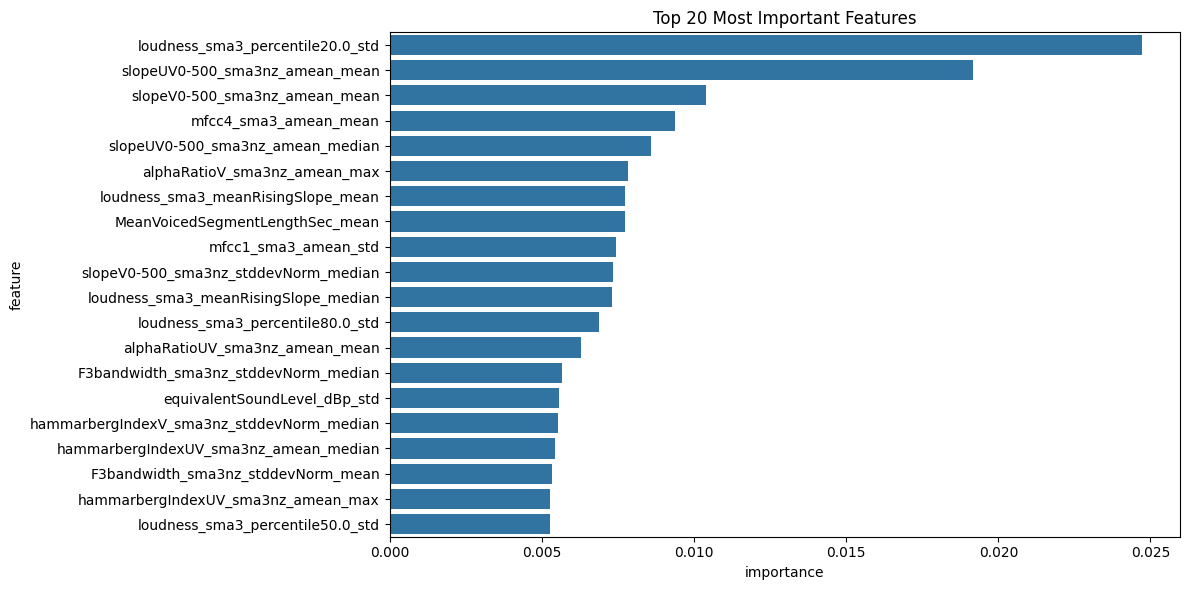


Fold 1
[0]	validation_0-mlogloss:1.08783
[100]	validation_0-mlogloss:0.80558
[200]	validation_0-mlogloss:0.78996
[299]	validation_0-mlogloss:0.79589
Fold 1 Log Loss: 0.7959

Fold 2
[0]	validation_0-mlogloss:1.08700
[100]	validation_0-mlogloss:0.77263
[200]	validation_0-mlogloss:0.74652
[299]	validation_0-mlogloss:0.75074
Fold 2 Log Loss: 0.7507

Fold 3
[0]	validation_0-mlogloss:1.08746
[100]	validation_0-mlogloss:0.81854
[200]	validation_0-mlogloss:0.81697
[299]	validation_0-mlogloss:0.82639
Fold 3 Log Loss: 0.8264

Fold 4
[0]	validation_0-mlogloss:1.08790
[100]	validation_0-mlogloss:0.79227
[200]	validation_0-mlogloss:0.76641
[299]	validation_0-mlogloss:0.77049
Fold 4 Log Loss: 0.7705

Fold 5
[0]	validation_0-mlogloss:1.08890
[100]	validation_0-mlogloss:0.82290
[200]	validation_0-mlogloss:0.80648
[299]	validation_0-mlogloss:0.80923
Fold 5 Log Loss: 0.8092

Mean Log Loss: 0.7905 (+/- 0.0270)

Overall OOF Log Loss: 0.7905


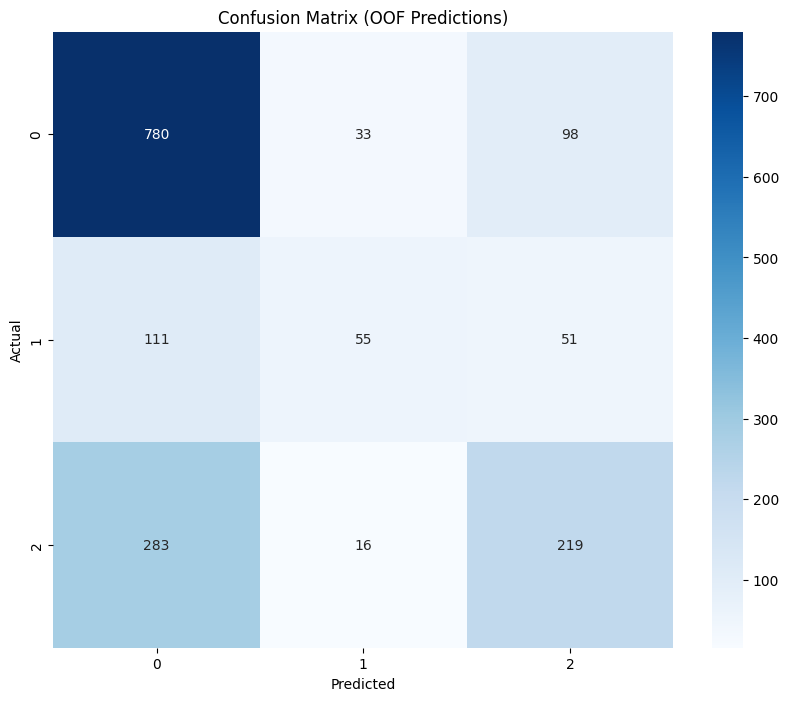

In [35]:
# First, let's prepare our target variable and features
train_labels_encoded = train_labels[['diagnosis_control', 'diagnosis_mci', 'diagnosis_adrd']].values
feature_cols = [col for col in train_final.columns if col != 'uid']

# Scale our features
scaler = StandardScaler()
X_train = scaler.fit_transform(train_final[feature_cols])
X_train = pd.DataFrame(X_train, columns=feature_cols)

# Initialize XGBoost classifier for feature importance
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    learning_rate=0.1,
    max_depth=4,
    n_estimators=100,
    random_state=RANDOM_STATE,
    scale_pos_weight=1,  # We'll adjust this later


)



# Fit model for feature importance
xgb_model.fit(X_train, train_labels_encoded.argmax(axis=1))

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot top 20 most important features
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Top 20 Most Important Features')
plt.tight_layout()
plt.show()

# Select top 100 features
top_features = feature_importance['feature'].head(100).tolist()

# Now let's implement a robust cross-validation strategy with class balancing
def train_model(X, y, test_data, feature_cols, n_splits=5):
    # Calculate class weights
    class_weights = dict(enumerate(len(y) / (3 * np.sum(y, axis=0))))

    # Initialize arrays for OOF predictions and test predictions
    oof_predictions = np.zeros((len(X), 3))
    test_predictions = np.zeros((len(test_data), 3))

    # Initialize StratifiedKFold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

    # Initialize scores list
    scores = []

    # Loop through folds
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y.argmax(axis=1)), 1):
        print(f'\nFold {fold}')

        # Split data
        X_train_fold = X[train_idx]
        y_train_fold = y[train_idx]
        X_val_fold = X[val_idx]
        y_val_fold = y[val_idx]

        # Initialize model
        model = xgb.XGBClassifier(

             objective='multi:softprob',
            num_class=3,
            learning_rate=0.03,  # Reduced learning rate
            max_depth=5,         # Slightly increased depth
            n_estimators=300,    # More trees
            subsample=0.85,
            colsample_bytree=0.85,
            min_child_weight=3,
            gamma=0.1,           # Added gamma for better pruning
            random_state=RANDOM_STATE
        )

        # Train model
        model.fit(
            X_train_fold, y_train_fold.argmax(axis=1),
            eval_set=[(X_val_fold, y_val_fold.argmax(axis=1))],
            #eval_metric='mlogloss',
            #early_stopping_rounds=50,
            verbose=100
        )

        # Make predictions
        val_pred = model.predict_proba(X_val_fold)
        oof_predictions[val_idx] = val_pred

        # Make test predictions
        test_predictions += model.predict_proba(test_data[feature_cols]) / n_splits

        # Calculate fold score
        fold_score = log_loss(y_val_fold, val_pred)
        scores.append(fold_score)
        print(f'Fold {fold} Log Loss: {fold_score:.4f}')

    # Print overall score
    print(f'\nMean Log Loss: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})')

    return oof_predictions, test_predictions, scores

# Train model using selected features
X_selected = X_train[top_features]
test_selected = scaler.transform(test_final[feature_cols])
test_selected = pd.DataFrame(test_selected, columns=feature_cols)[top_features]

oof_preds, test_preds, cv_scores = train_model(
    X_selected.values,
    train_labels_encoded,
    test_selected,
    top_features
)

# Create submission
submission = pd.DataFrame({
    'uid': test_final['uid'],
    'diagnosis_control': test_preds[:, 0],
    'diagnosis_mci': test_preds[:, 1],
    'diagnosis_adrd': test_preds[:, 2]
})

# Save submission
submission.to_csv('submission.csv', index=False)

# Print final validation score
print(f'\nOverall OOF Log Loss: {log_loss(train_labels_encoded, oof_preds):.4f}')

# Plot confusion matrix for OOF predictions
plt.figure(figsize=(10, 8))
cm = confusion_matrix(train_labels_encoded.argmax(axis=1), oof_preds.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (OOF Predictions)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Training xgb for feature importance...


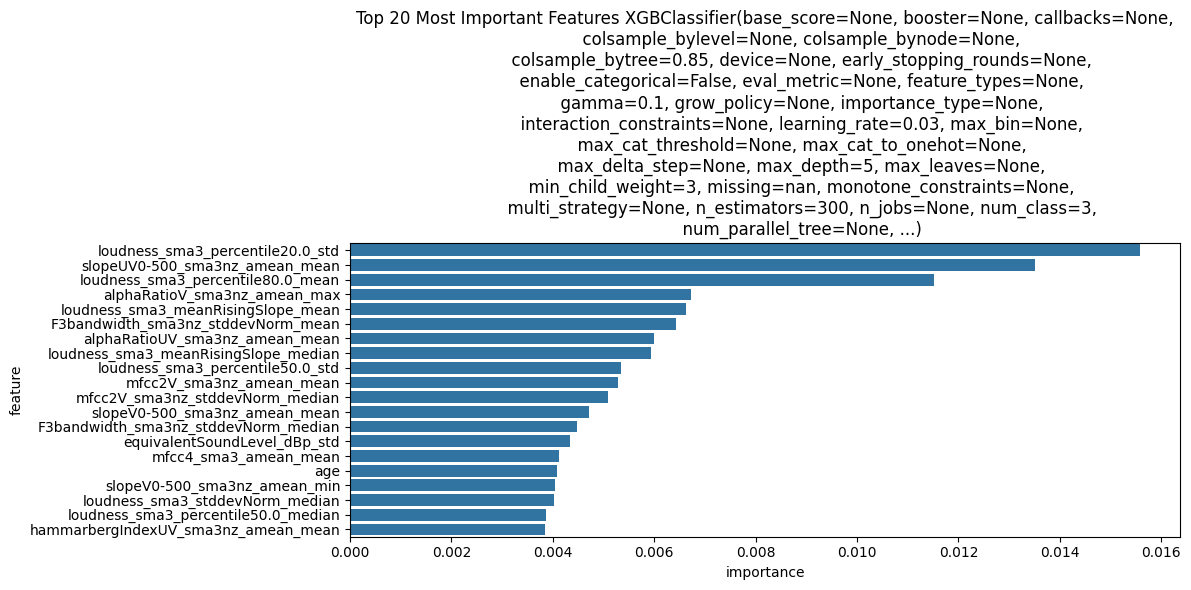


Training catboost for feature importance...


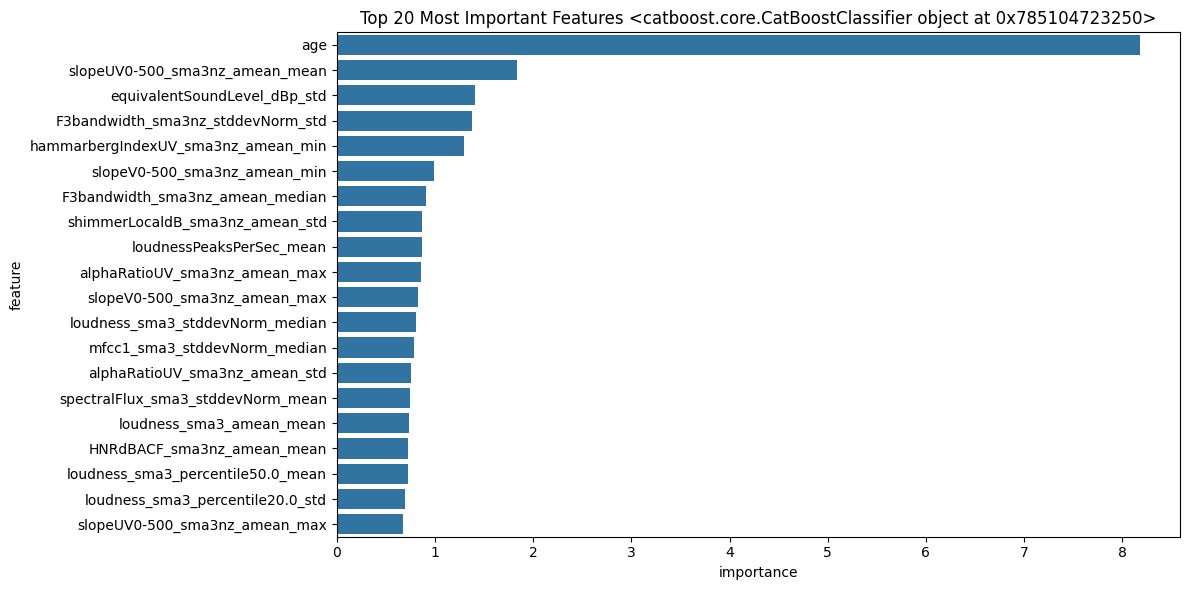


Training rf for feature importance...


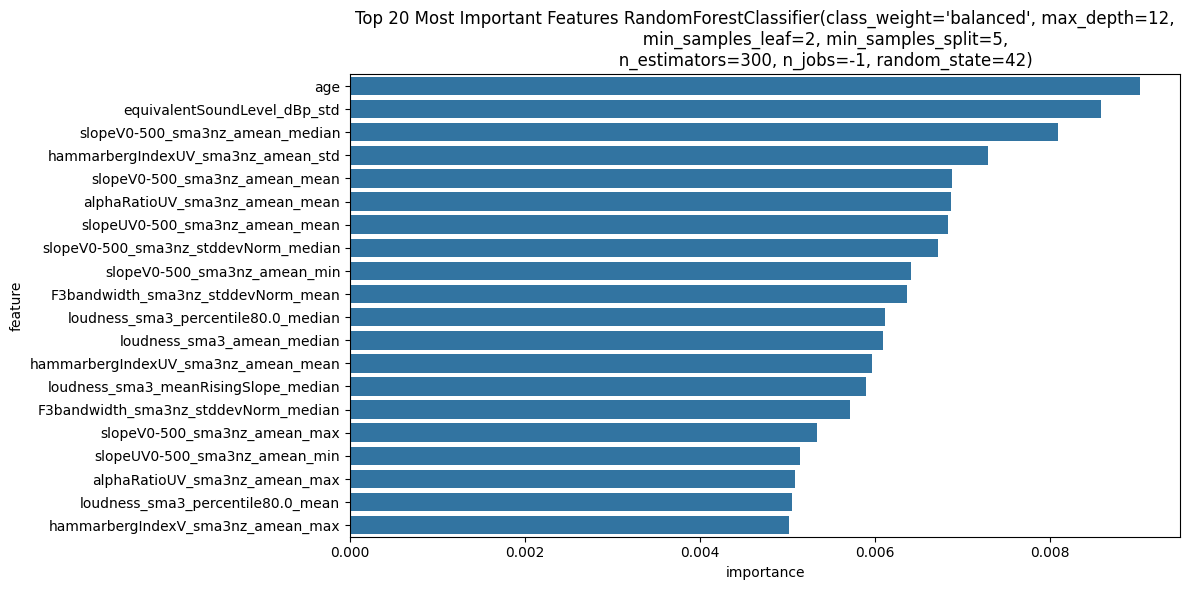

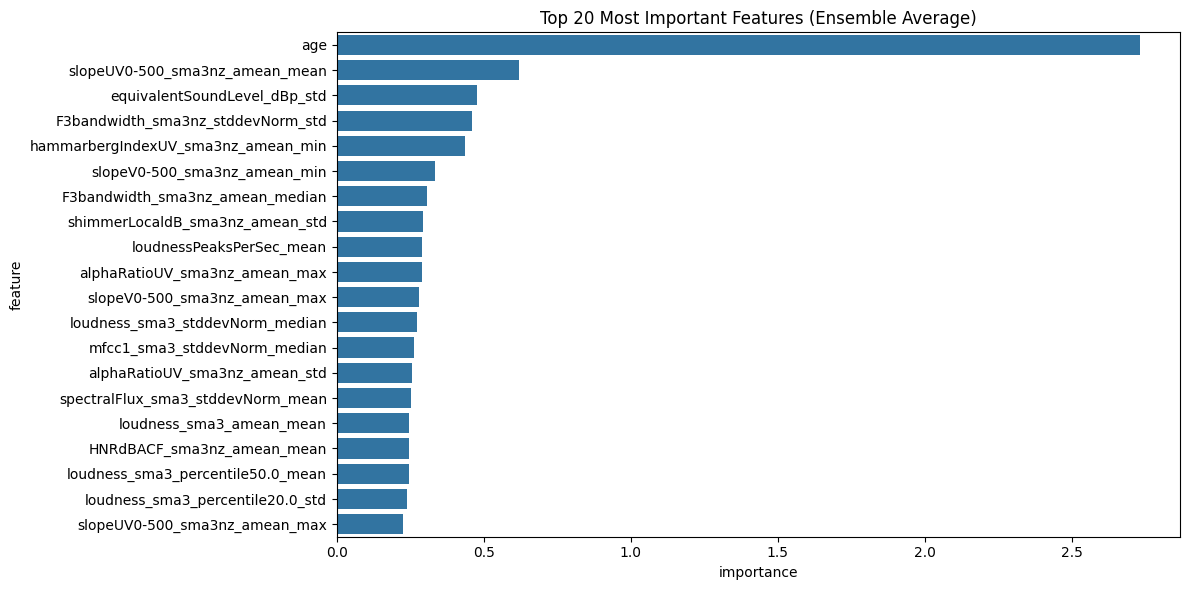

In [22]:
# First, let's prepare our target variable and features
train_labels_encoded = train_labels[['diagnosis_control', 'diagnosis_mci', 'diagnosis_adrd']].values
feature_cols = [col for col in train_final.columns if col != 'uid']

# Scale our features
scaler = StandardScaler()
X_train = scaler.fit_transform(train_final[feature_cols])
X_train = pd.DataFrame(X_train, columns=feature_cols)

# Initialize base models for feature importance and ensemble
def initialize_models(random_state):
    models = {
        'xgb': xgb.XGBClassifier(
            objective='multi:softprob',
            num_class=3,
            learning_rate=0.03,  # Reduced learning rate
            max_depth=5,         # Slightly increased depth
            n_estimators=300,    # More trees
            subsample=0.85,
            colsample_bytree=0.85,
            min_child_weight=3,
            gamma=0.1,           # Added gamma for better pruning
            random_state=random_state
        ),
        'catboost': CatBoostClassifier(
            iterations=300,
            learning_rate=0.03,
            depth=5,
            l2_leaf_reg=3,
            loss_function='MultiClass',
            random_seed=random_state,
            verbose=False
        ),
        'rf': RandomForestClassifier(
            n_estimators=300,
            max_depth=12,
            min_samples_split=5,
            min_samples_leaf=2,
            max_features='sqrt',
            class_weight='balanced',
            random_state=random_state,
            n_jobs=-1
        )
    }
    return models

# Get feature importance from multiple models
def get_ensemble_feature_importance(X, y, feature_cols, random_state):
    models = initialize_models(random_state)
    feature_importance_dict = {}

    for model_name, model in models.items():
        print(f"\nTraining {model_name} for feature importance...")
        model.fit(X, y.argmax(axis=1))
        feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': model.feature_importances_
        })
        feature_importance = feature_importance.sort_values('importance', ascending=False)

        # Plot top 20 most important features
        plt.figure(figsize=(12, 6))
        sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
        plt.title(f'Top 20 Most Important Features {model}')
        plt.tight_layout()
        plt.show()

        if hasattr(model, 'feature_importances_'):
            feature_importance_dict[model_name] = pd.DataFrame({
                'feature': feature_cols,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)

    # Aggregate feature importance across models
    all_importance = pd.DataFrame()
    for model_name, imp_df in feature_importance_dict.items():
        imp_df = imp_df.copy()
        imp_df['model'] = model_name
        all_importance = pd.concat([all_importance, imp_df])

    # Calculate mean importance across models
    mean_importance = all_importance.groupby('feature')['importance'].mean().reset_index()
    return mean_importance.sort_values('importance', ascending=False)


# Get ensemble feature importance
feature_importance = get_ensemble_feature_importance(X_train, train_labels_encoded, feature_cols, RANDOM_STATE)

# Plot top 20 most important features
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Top 20 Most Important Features (Ensemble Average)')
plt.tight_layout()
plt.show()

# Select top features
top_features = feature_importance['feature'].head(100).tolist()



Training xgb for feature importance...


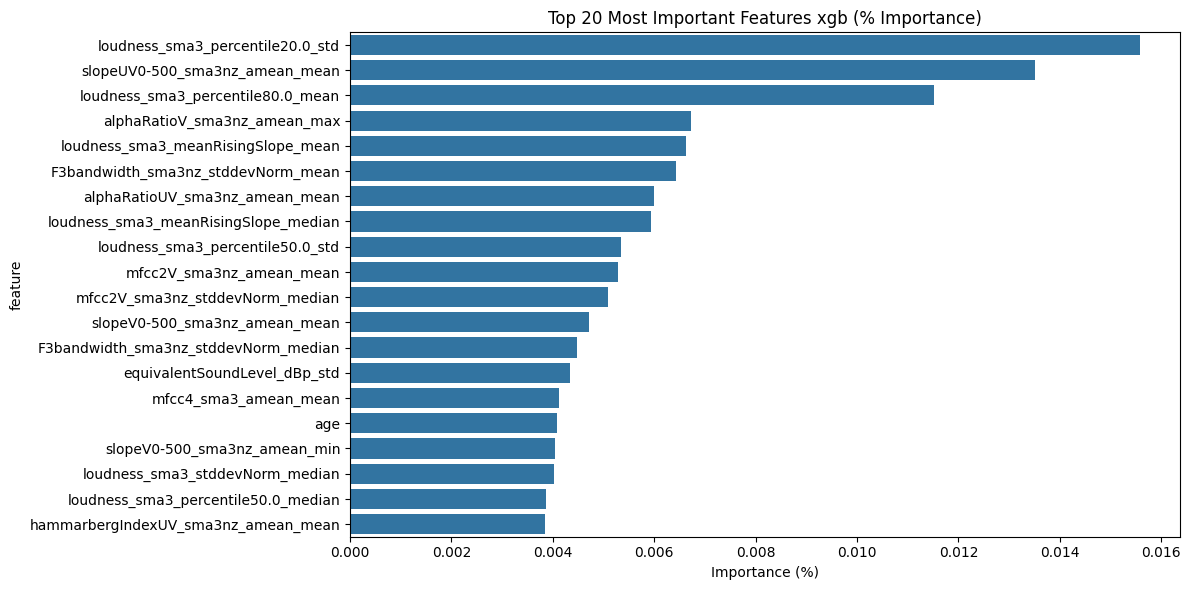


Training catboost for feature importance...


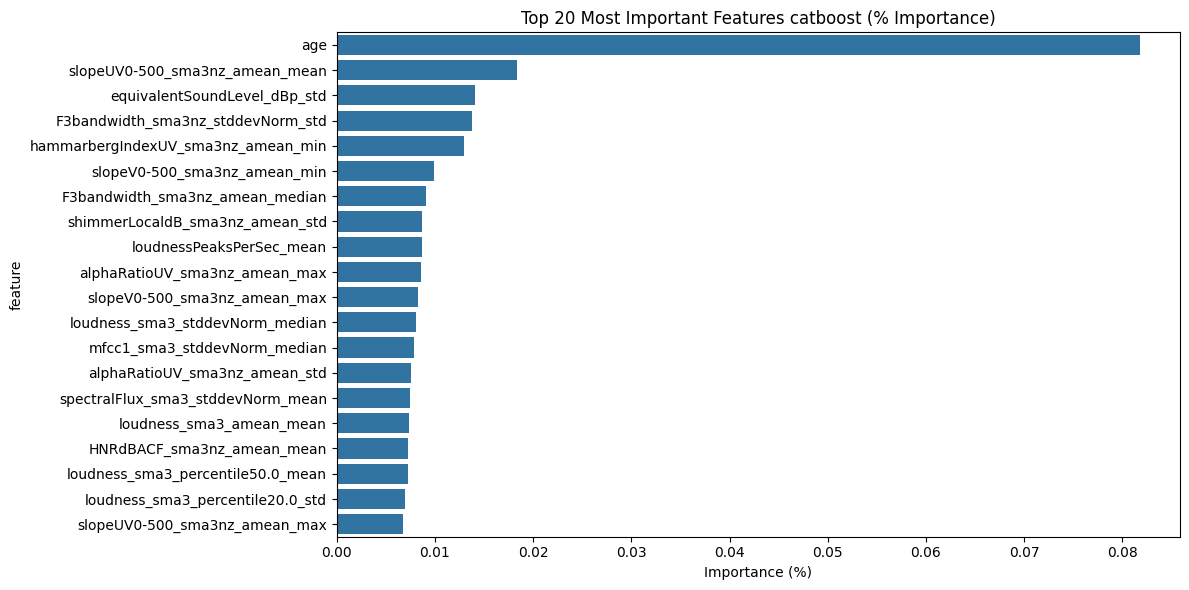


Training rf for feature importance...


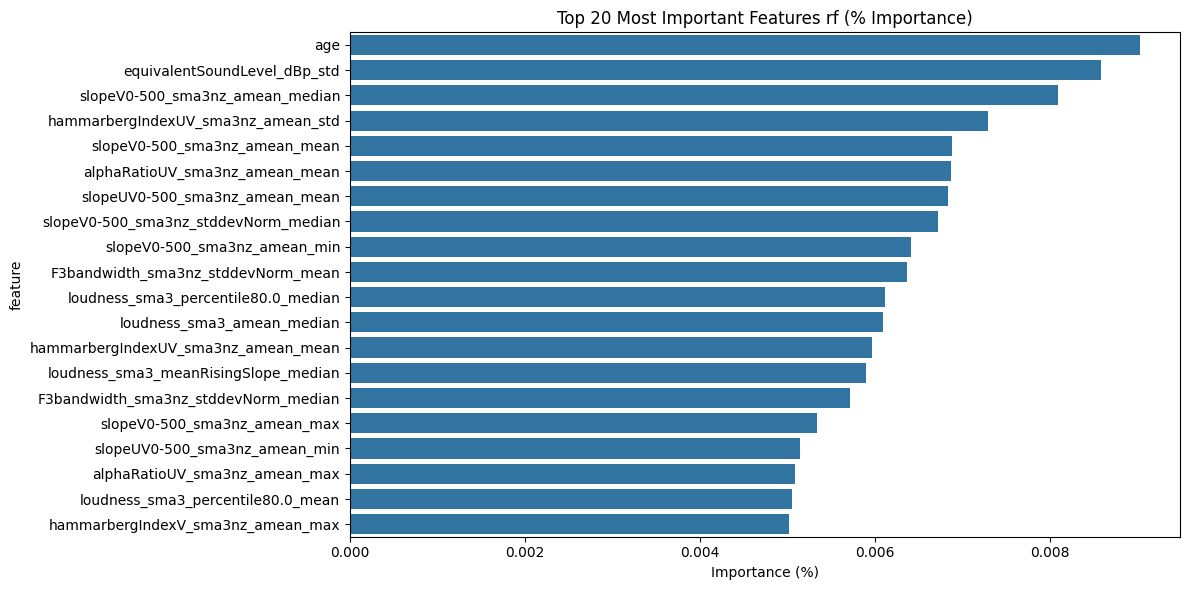

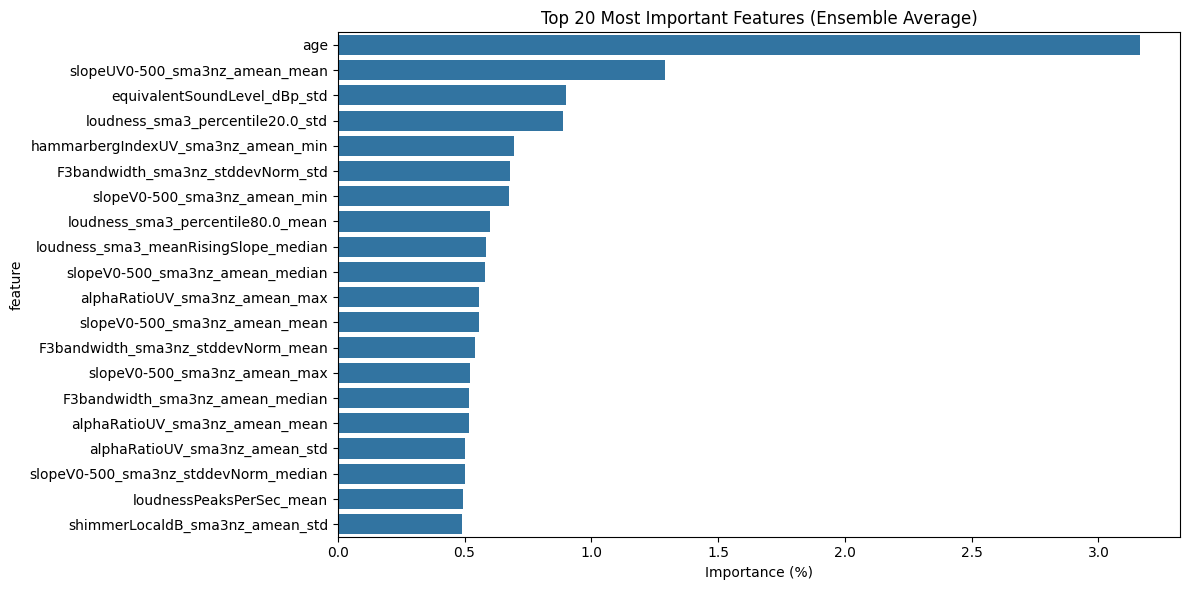

In [23]:
# First, let's prepare our target variable and features
train_labels_encoded = train_labels[['diagnosis_control', 'diagnosis_mci', 'diagnosis_adrd']].values
feature_cols = [col for col in train_final.columns if col != 'uid']

# Scale our features
scaler = StandardScaler()
X_train = scaler.fit_transform(train_final[feature_cols])
X_train = pd.DataFrame(X_train, columns=feature_cols)

# Initialize base models for feature importance and ensemble
def initialize_models(random_state):
    models = {
        'xgb': xgb.XGBClassifier(
            objective='multi:softprob',
            num_class=3,
            learning_rate=0.03,  # Reduced learning rate
            max_depth=5,         # Slightly increased depth
            n_estimators=300,    # More trees
            subsample=0.85,
            colsample_bytree=0.85,
            min_child_weight=3,
            gamma=0.1,           # Added gamma for better pruning
            random_state=random_state
        ),
        'catboost': CatBoostClassifier(
            iterations=300,
            learning_rate=0.03,
            depth=5,
            l2_leaf_reg=3,
            loss_function='MultiClass',
            random_seed=random_state,
            verbose=False
        ),
        'rf': RandomForestClassifier(
            n_estimators=300,
            max_depth=12,
            min_samples_split=5,
            min_samples_leaf=2,
            max_features='sqrt',
            class_weight='balanced',
            random_state=random_state,
            n_jobs=-1
        )
    }
    return models

# Get feature importance from multiple models
def get_ensemble_feature_importance(X, y, feature_cols, random_state):
    models = initialize_models(random_state)
    feature_importance_dict = {}

    def percentage_importance(importance_values):
        total = sum(importance_values)
        return [x/total for x in importance_values]

    for model_name, model in models.items():
        print(f"\nTraining {model_name} for feature importance...")
        model.fit(X, y.argmax(axis=1))

        # Normalize feature importances to percentages
        normalized_importance = percentage_importance(model.feature_importances_)

        feature_importance = pd.DataFrame({
            'feature': feature_cols,
            'importance': normalized_importance
        })
        feature_importance = feature_importance.sort_values('importance', ascending=False)

        # Plot top 20 most important features
        plt.figure(figsize=(12, 6))
        sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
        plt.title(f'Top 20 Most Important Features {model_name} (% Importance)')
        plt.xlabel('Importance (%)')
        plt.tight_layout()
        plt.show()

        if hasattr(model, 'feature_importances_'):
            feature_importance_dict[model_name] = pd.DataFrame({
                'feature': feature_cols,
                'importance': normalized_importance
            }).sort_values('importance', ascending=False)

    # Aggregate normalized feature importance across models
    all_importance = pd.DataFrame()
    for model_name, imp_df in feature_importance_dict.items():
        imp_df = imp_df.copy()
        imp_df['model'] = model_name
        all_importance = pd.concat([all_importance, imp_df])

    # Calculate mean importance across models
    mean_importance = all_importance.groupby('feature')['importance'].mean().reset_index()

    # Convert to percentage for final results
    mean_importance['importance'] = mean_importance['importance'] * 100

    return mean_importance.sort_values('importance', ascending=False)


# Get ensemble feature importance
feature_importance = get_ensemble_feature_importance(X_train, train_labels_encoded, feature_cols, RANDOM_STATE)

# Plot top 20 most important features
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Top 20 Most Important Features (Ensemble Average)')
plt.xlabel('Importance (%)')
plt.tight_layout()
plt.show()

# Select top features
top_features = feature_importance['feature'].head(100).tolist()



Fold 1

Training xgb...
xgb Fold 1 Log Loss: 0.7883

Training catboost...
catboost Fold 1 Log Loss: 0.7924

Training rf...
rf Fold 1 Log Loss: 0.8109

Fold 2

Training xgb...
xgb Fold 2 Log Loss: 0.7732

Training catboost...
catboost Fold 2 Log Loss: 0.7757

Training rf...
rf Fold 2 Log Loss: 0.7991

Fold 3

Training xgb...
xgb Fold 3 Log Loss: 0.8176

Training catboost...
catboost Fold 3 Log Loss: 0.8021

Training rf...
rf Fold 3 Log Loss: 0.8062

Fold 4

Training xgb...
xgb Fold 4 Log Loss: 0.7547

Training catboost...
catboost Fold 4 Log Loss: 0.7768

Training rf...
rf Fold 4 Log Loss: 0.7904

Fold 5

Training xgb...
xgb Fold 5 Log Loss: 0.7732

Training catboost...
catboost Fold 5 Log Loss: 0.7917

Training rf...
rf Fold 5 Log Loss: 0.8118

xgb Mean Log Loss: 0.7814 (+/- 0.0210)

catboost Mean Log Loss: 0.7878 (+/- 0.0101)

rf Mean Log Loss: 0.8037 (+/- 0.0080)

Stacking Ensemble OOF Log Loss: 0.8882015257276954
Weighted Ensemble OOF Log Loss: 0.7741165651941448


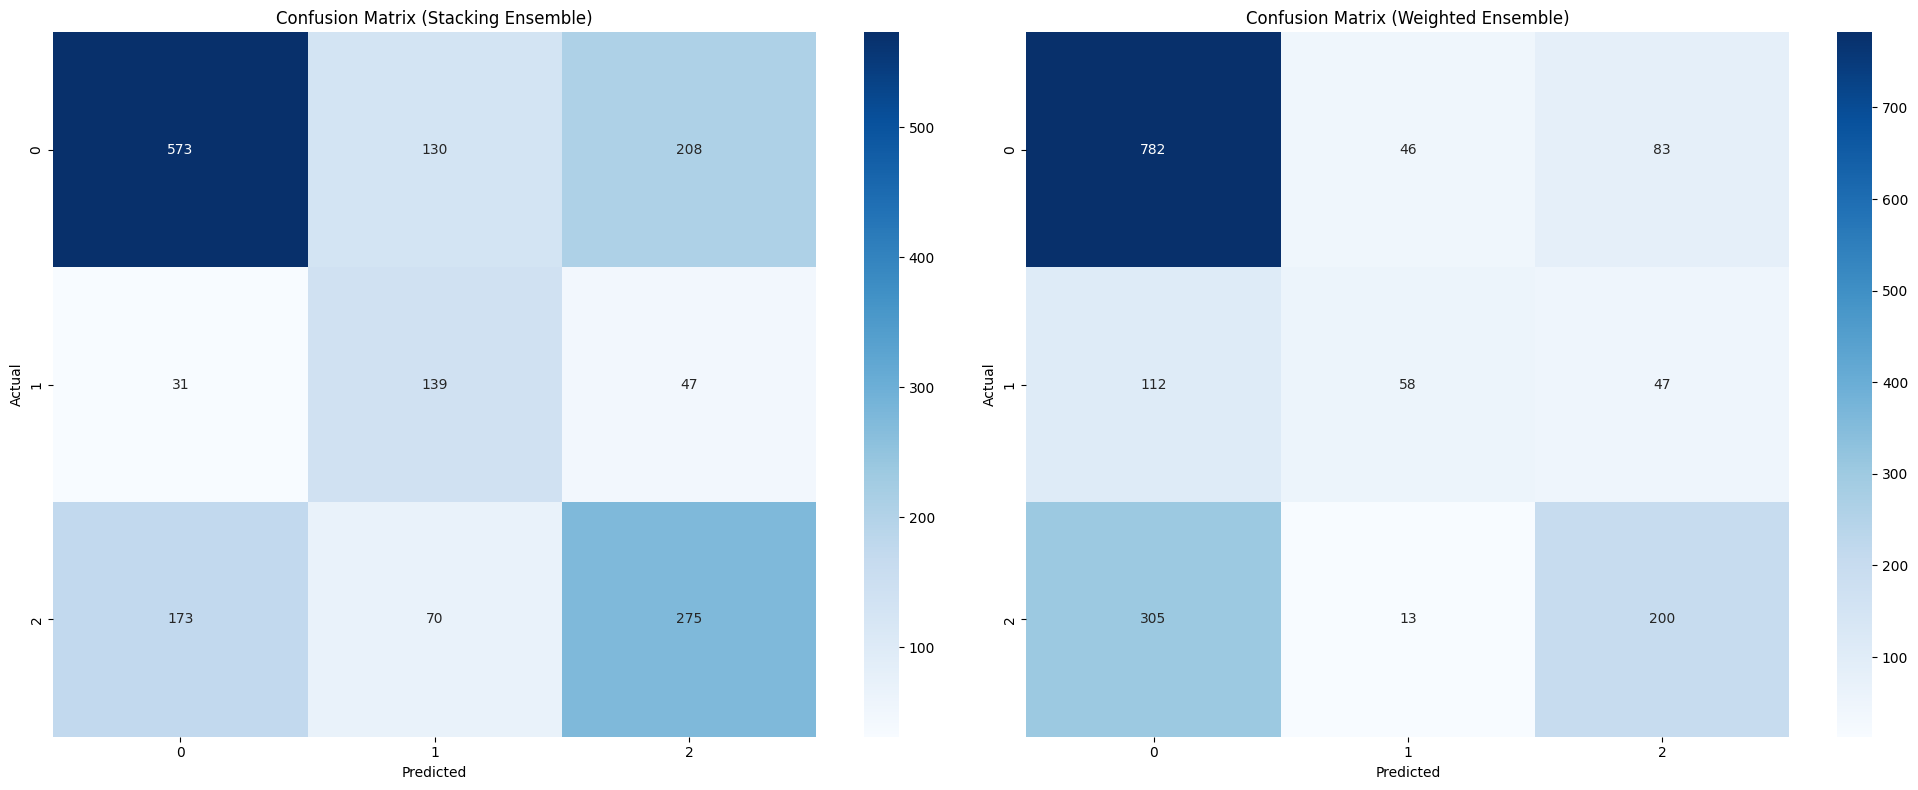

In [29]:
top_features = feature_importance['feature'].head(100).tolist()

def train_ensemble_model(X, y, test_data, feature_cols, n_splits=5):
    # Initialize arrays for OOF and test predictions for each model
    models = initialize_models(RANDOM_STATE)
    oof_predictions = {model_name: np.zeros((len(X), 3)) for model_name in models.keys()}
    test_predictions = {model_name: np.zeros((len(test_data), 3)) for model_name in models.keys()}

    # Initialize meta-features for stacking
    meta_features_train = np.zeros((len(X), len(models) * 3))
    meta_features_test = np.zeros((len(test_data), len(models) * 3))

    # Initialize StratifiedKFold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

    # Dictionary to store scores for each model
    model_scores = {model_name: [] for model_name in models.keys()}

    # Loop through folds
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y.argmax(axis=1)), 1):
        print(f'\nFold {fold}')

        X_train_fold = X[train_idx]
        y_train_fold = y[train_idx]
        X_val_fold = X[val_idx]
        y_val_fold = y[val_idx]

        # Train each model
        for model_name, model in models.items():
            print(f"\nTraining {model_name}...")

            if model_name == 'catboost':
                model.fit(
                    X_train_fold, y_train_fold.argmax(axis=1),
                    eval_set=[(X_val_fold, y_val_fold.argmax(axis=1))],
                    early_stopping_rounds=50,
                    verbose=False
                )
            elif model_name == 'xgb':
                model.fit(
                    X_train_fold, y_train_fold.argmax(axis=1),
                    eval_set=[(X_val_fold, y_val_fold.argmax(axis=1))],
                    #early_stopping_rounds=50,
                    verbose=False
                )
            else:
                model.fit(X_train_fold, y_train_fold.argmax(axis=1))

            # Make predictions
            val_pred = model.predict_proba(X_val_fold)
            oof_predictions[model_name][val_idx] = val_pred
            test_predictions[model_name] += model.predict_proba(test_data[feature_cols]) / n_splits

            # Calculate fold score
            fold_score = log_loss(y_val_fold, val_pred)
            model_scores[model_name].append(fold_score)
            print(f'{model_name} Fold {fold} Log Loss: {fold_score:.4f}')

    # Print overall scores
    for model_name, scores in model_scores.items():
        print(f'\n{model_name} Mean Log Loss: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})')

    # Calculate optimal weights based on validation performance
    model_weights = {}
    for model_name, scores in model_scores.items():
        # Use inverse of mean log loss as weight
        weight = 1 / np.mean(scores)
        model_weights[model_name] = weight

    # Normalize weights
    total_weight = sum(model_weights.values())
    model_weights = {k: v/total_weight for k, v in model_weights.items()}

    # Create weighted ensemble predictions
    weighted_oof_preds = np.zeros((len(X), 3))
    weighted_test_preds = np.zeros((len(test_data), 3))

    for model_name in models.keys():
        weighted_oof_preds += model_weights[model_name] * oof_predictions[model_name]
        weighted_test_preds += model_weights[model_name] * test_predictions[model_name]

    # Prepare meta-features for stacking
    for i, model_name in enumerate(models.keys()):
        meta_features_train[:, i*3:(i+1)*3] = oof_predictions[model_name]
        meta_features_test[:, i*3:(i+1)*3] = test_predictions[model_name]

    # Train meta-classifier with optimal parameters
    meta_classifier = LogisticRegression(
        multi_class='multinomial',
        max_iter=2000,
        C=0.1,           # Increased regularization
        solver='lbfgs',
        class_weight='balanced'
    )

    # Train meta-classifier
    meta_classifier.fit(meta_features_train, y.argmax(axis=1))

    # Make final predictions
    final_oof_preds = meta_classifier.predict_proba(meta_features_train)
    final_test_preds = meta_classifier.predict_proba(meta_features_test)

    return {
        'stacking_oof': final_oof_preds,
        'stacking_test': final_test_preds,
        'weighted_oof': weighted_oof_preds,
        'weighted_test': weighted_test_preds,
        'individual_models': {
            'oof': oof_predictions,
            'test': test_predictions
        },
        'scores': model_scores,
        'weights': model_weights
    }

# Train ensemble model using selected features
X_selected = X_train[top_features]
test_selected = scaler.transform(test_final[feature_cols])
test_selected = pd.DataFrame(test_selected, columns=feature_cols)[top_features]

ensemble_results = train_ensemble_model(
    X_selected.values,
    train_labels_encoded,
    test_selected,
    top_features
)

# Create submissions for both stacking and weighted ensemble
submission_stacking = pd.DataFrame({
    'uid': test_final['uid'],
    'diagnosis_control': ensemble_results['stacking_test'][:, 0],
    'diagnosis_mci': ensemble_results['stacking_test'][:, 1],
    'diagnosis_adrd': ensemble_results['stacking_test'][:, 2]
})

submission_weighted = pd.DataFrame({
    'uid': test_final['uid'],
    'diagnosis_control': ensemble_results['weighted_test'][:, 0],
    'diagnosis_mci': ensemble_results['weighted_test'][:, 1],
    'diagnosis_adrd': ensemble_results['weighted_test'][:, 2]
})

# Save submissions
submission_stacking.to_csv('submission_stacking.csv', index=False)
submission_weighted.to_csv('submission_weighted.csv', index=False)

# Print final validation scores
print('\nStacking Ensemble OOF Log Loss:',
      log_loss(train_labels_encoded, ensemble_results['stacking_oof']))
print('Weighted Ensemble OOF Log Loss:',
      log_loss(train_labels_encoded, ensemble_results['weighted_oof']))

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Stacking Ensemble Confusion Matrix
cm_stacking = confusion_matrix(
    train_labels_encoded.argmax(axis=1),
    ensemble_results['stacking_oof'].argmax(axis=1)
)
sns.heatmap(cm_stacking, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix (Stacking Ensemble)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Weighted Ensemble Confusion Matrix
cm_weighted = confusion_matrix(
    train_labels_encoded.argmax(axis=1),
    ensemble_results['weighted_oof'].argmax(axis=1)
)
sns.heatmap(cm_weighted, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix (Weighted Ensemble)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [ ]:
# Use selected top features for training
X_selected = X_train[top_features]

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'n_estimators': [100, 200, 300, 400],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 2, 3],
    'scale_pos_weight': [1, 2, 3]
}

# Initialize XGBoost model
xgb_model = xgb.XGBClassifier(objective='multi:softprob', num_class=3, random_state=RANDOM_STATE)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50,
    scoring='neg_log_loss',
    cv=5,
    verbose=1,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Fit the model
random_search.fit(X_selected, train_labels_encoded.argmax(axis=1))

# Get best parameters
best_params = random_search.best_params_
print("Best parameters found: ", best_params)
print("Best Log Loss: ", -random_search.best_score_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:41:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters found:  {'subsample': 0.6, 'scale_pos_weight': 2, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Best Log Loss:  0.8040125057062528
